## Data Analysis

In [2]:
import matplotlib.pyplot as plt

def char_plot(set, sizes, labels):
    colors = ['yellowgreen', 'gold', 'lightskyblue']

    plt.figure(figsize=(5, 4))
    plt.pie(sizes, labels=labels, colors=colors, startangle=90, autopct='%1.1f%%')

    # Add circle at center to create the effect of a cheese graph
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.title(set.capitalize() + ' Set Class Division')
    plt.axis('equal')  # Ensure circular pie
    plt.tight_layout()  # Avoid overlapping labels
    plt.show()

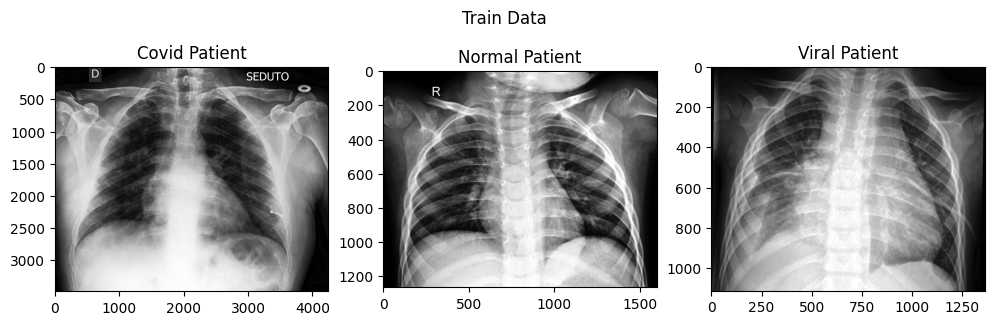

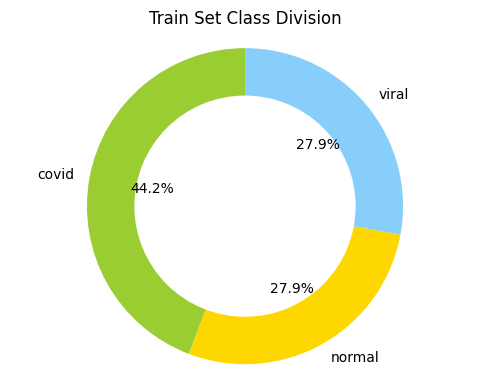

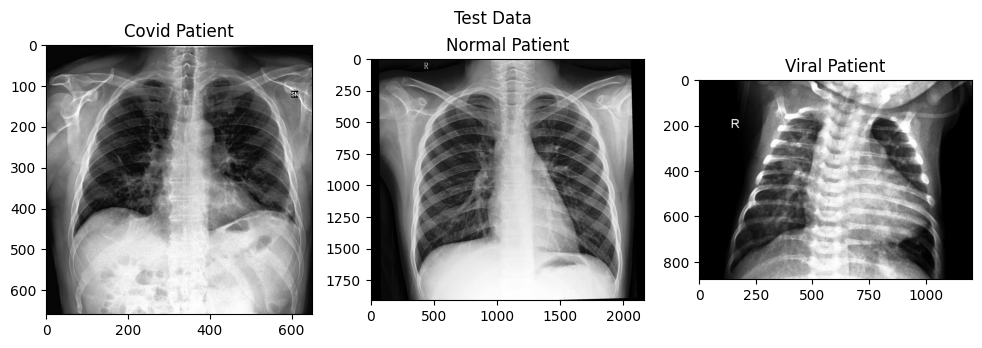

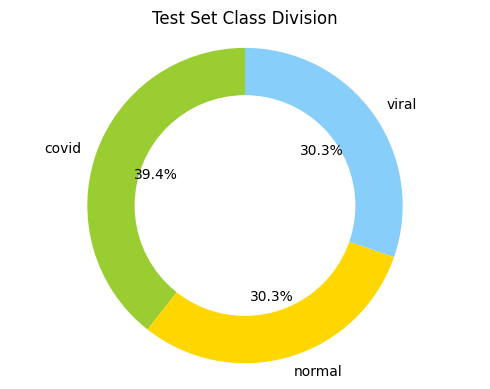

In [26]:
import os
import numpy as np
import matplotlib.image as mpimg

data_path = "./data"
set_path = ["train", "test"]
labels = ['covid', 'normal', 'viral']
sizes = np.zeros(3, dtype=np.int32)

for set in set_path:
    fig = plt.figure(figsize=(12, 3.5))
    fig.suptitle(set.capitalize() + " Data")
    
    for ix, l in enumerate(labels):
        directory_path = data_path + "/" + set + "/" + l
        sizes[ix] = len(os.listdir(directory_path))
        plt.subplot(1, 3, ix + 1)
        plt.imshow(mpimg.imread(directory_path + '/' + str(ix + 1) + ".jpeg"))
        plt.title(l.capitalize() + " Patient")
    plt.show() 

    char_plot(set, sizes, labels)

## Data Augmentation

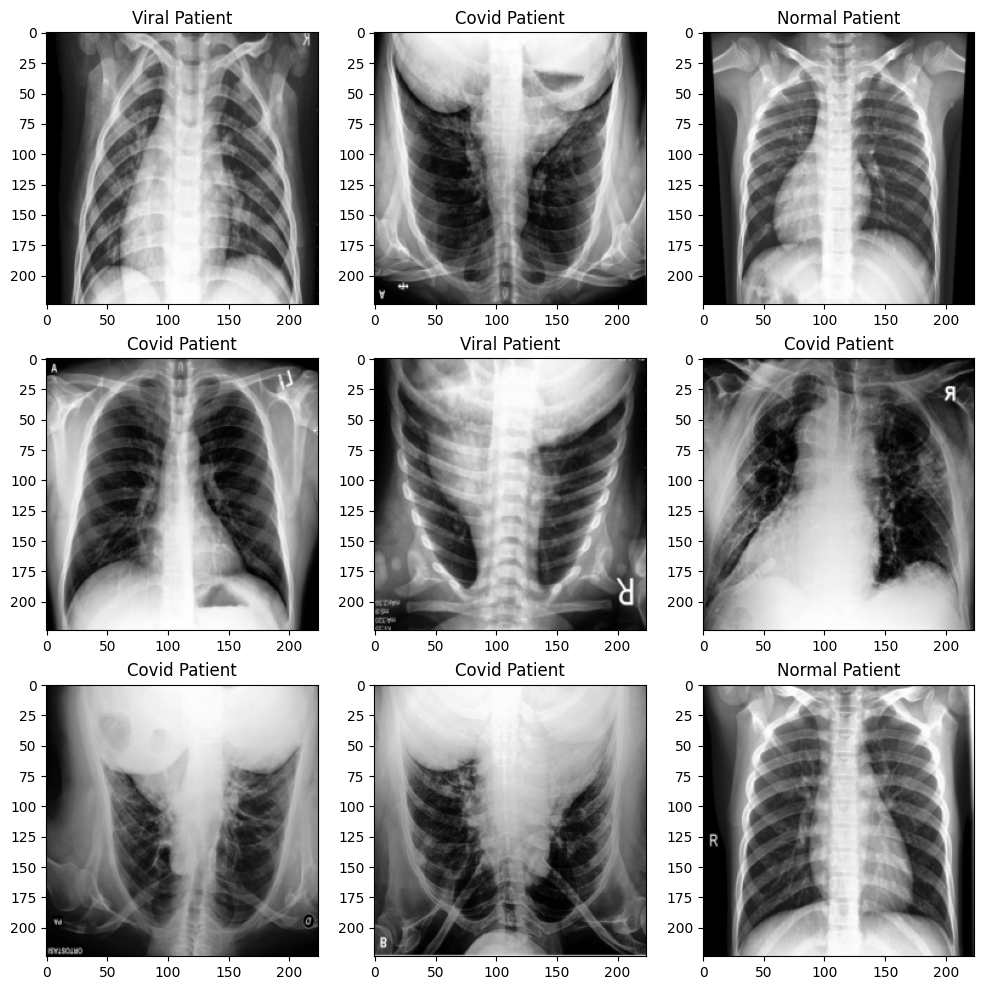

In [45]:
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

augmentation_transform = transforms.Compose([
    transforms.RandomEqualize(1.0),  # Histogram equalization (./docs/papers/article-3.pdf)
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),  # TODO Does it make sense ¿?
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

batch_size = 3
augmentation_dataset = datasets.ImageFolder('./data/train/', transform=augmentation_transform)
augmentation_dataloader = DataLoader(augmentation_dataset, batch_size=batch_size, shuffle=True)

iterable = iter(augmentation_dataloader)
fig = plt.figure(figsize=(batch_size * 4, batch_size * 4))

for bix in range(0, batch_size):
    image_list, label_list = next(iterable)
    
    for ix, (image, label) in enumerate(zip(image_list, label_list), 1):
        plt.subplot(batch_size, batch_size, bix * batch_size + ix)  # [n_rows, n_cols, index]
        plt.imshow(image.numpy().transpose((1, 2, 0)))  # (C, H, W) -> (H, W, C)
        plt.title(augmentation_dataset.classes[label].capitalize() + " Patient")

plt.show()

## Network Architecture Design

In [22]:
import torch.nn as nn
import torchvision

# ./docs/papers/article-2.pdf
# Multiclass Classification for Detection of COVID-19 Infection in Chest X-Rays Using CNN
class TabukNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Check stride and padding
        self.conv_3_32 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_32_64 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv_64_32 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=1)
        self.fc = nn.Linear(in_features=64, out_features=3)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.maxpool(self.conv_3_32(x))
        x = self.maxpool(self.conv_32_64(x))
        
        for _ in range(2):
            x = self.maxpool(self.conv_64_32(x))
            x = self.maxpool(self.conv_32_64(x))

        return self.softmax(self.fc(x.view(-1)))


# ./docs/papers/article-3.pdf
# A Deep Transfer Learning Approach to Diagnose Covid-19 using X-ray Images
class ChittagongNet(nn.Module):  # TODO Histogram Equalization ¿?
    def __init__(self, mode):
        super().__init__()

        self.mode = mode

        # Very Deep Convolutional Networks for Large-Scale Image Recognition
        # https://arxiv.org/abs/1409.1556
        self.vgg16 = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)
        self.vgg19 = torchvision.models.vgg19(weights=torchvision.models.VGG19_Weights.DEFAULT)

        # MobileNetV2: Inverted Residuals and Linear Bottlenecks
        # https://arxiv.org/abs/1801.04381
        self.mobileNetV2 = torchvision.models.mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights.DEFAULT)

        # Replace fully connected layers
            
            # GlobalAveragePooling2D
            # Dense(1024, activation='relu')
            # Dense(1024, activation='relu')
            # Dense(512, activation='relu')
            # Dense(3, activation='softmax')
        
    def forward(self, x):
        return x  # TODO

## Network Training and Validation

In [ ]:
# Cross validation

## Results